In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_extraction, model_selection, preprocessing, linear_model, svm
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [4]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [5]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [6]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

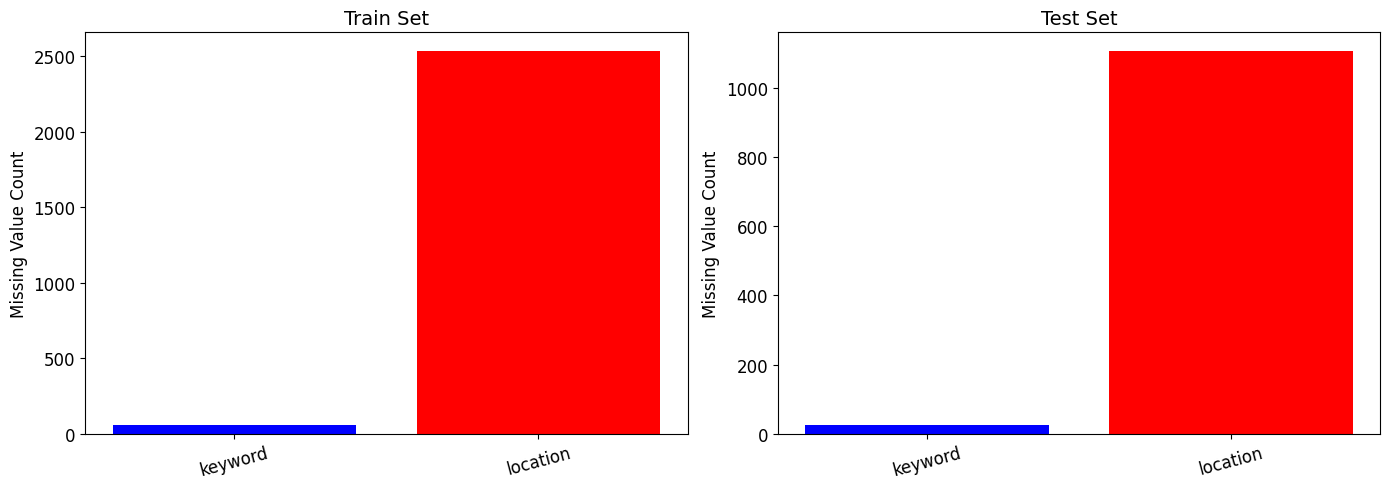

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define missing columns
missing_cols = ['keyword', 'location']

# Compute missing values ONCE
missing_values = {
    "train": train_df[missing_cols].isnull().sum(),
    "test": test_df[missing_cols].isnull().sum()
}

# Plot missing values efficiently
fig, axes = plt.subplots(ncols=2, figsize=(14, 5), dpi=100)

for i, (key, values) in enumerate(missing_values.items()):
    axes[i].bar(values.index, values.values, color=['blue', 'red'])
    axes[i].set_title(f"{key.capitalize()} Set", fontsize=14)
    axes[i].set_ylabel('Missing Value Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

# Efficiently fill missing values in both DataFrames using vectorized approach
fill_values = {col: f'no_{col}' for col in missing_cols}
train_df.fillna(value=fill_values, inplace=True)
test_df.fillna(value=fill_values, inplace=True)


In [7]:
# Text Vectorization using CountVectorizer
vectorizer = feature_extraction.text.CountVectorizer()



## let's get counts for the first 5 tweets in the data
example_train_vectors = vectorizer.fit_transform(train_df["text"][0:5])

In [8]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [9]:
train_vectors = vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = vectorizer.transform(test_df["text"])

Ridge Classifier Accuracy: 0.6672
XGBoost Accuracy: 0.6836
SVC Accuracy: 0.6773
Neural Network Accuracy: 0.7327
Best Model: Neural Network


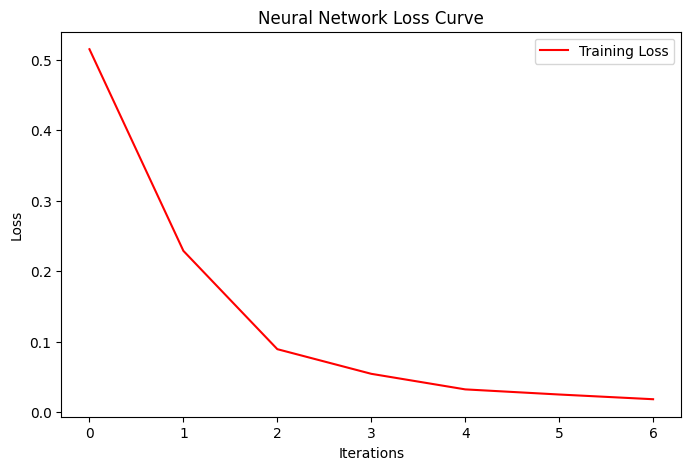

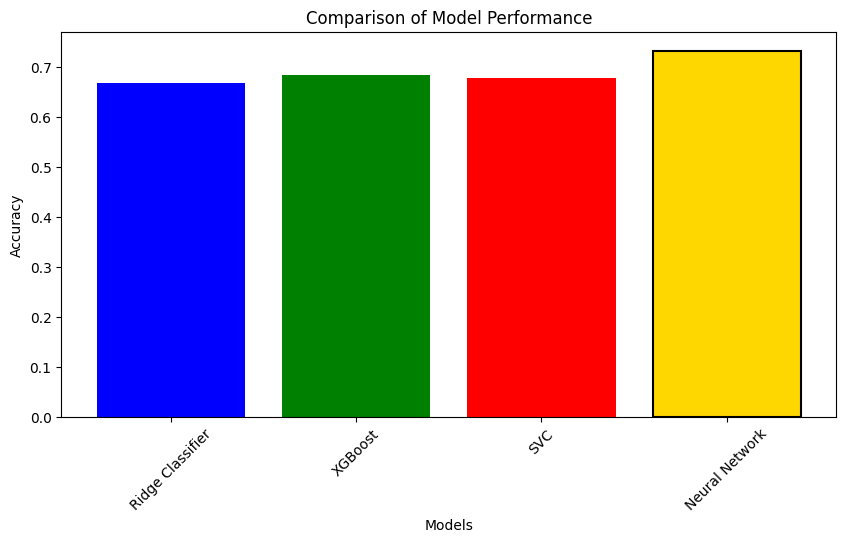

In [10]:
# Define models (with tracking for NN and XGBoost)
models = {
    "Ridge Classifier": linear_model.RidgeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss',n_jobs=-1 ),
    "SVC": svm.SVC(kernel='linear', probability=True),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        max_iter=100,
        early_stopping=True,
        n_iter_no_change=5,
        batch_size=64 
    )
}

# Evaluate models using cross-validation
scores = {}
for name, model in models.items():
    cv_score = cross_val_score(model, train_vectors, train_df['target'], cv=5, scoring='accuracy',n_jobs=-1 ).mean()
    scores[name] = cv_score
    print(f"{name} Accuracy: {cv_score:.4f}")

# Select the best model
best_model_name = max(scores, key=scores.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")

# Special case: Track learning progress for XGBoost
if best_model_name == "XGBoost":
    eval_set = [(train_vectors, train_df['target'])]
    best_model.fit(train_vectors, train_df['target'], eval_set=eval_set, verbose=True)

    # Retrieve loss over iterations
    results = best_model.evals_result()
    plt.figure(figsize=(8, 5))
    plt.plot(results['validation_0']['logloss'], label="Training Log Loss", color="blue")
    plt.xlabel("Iterations")
    plt.ylabel("Log Loss")
    plt.title("XGBoost Training Loss Over Iterations")
    plt.legend()
    plt.show()

# Train the best model on the full training data
best_model.fit(train_vectors, train_df['target'])

# Special case: Neural Network Loss Curve
if best_model_name == "Neural Network":
    plt.figure(figsize=(8, 5))
    plt.plot(best_model.loss_curve_, label="Training Loss", color="red")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Neural Network Loss Curve")
    plt.legend()
    plt.show()


# Visualization of Model Performance
plt.figure(figsize=(10, 5))
plt.bar(scores.keys(), scores.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Performance")
plt.xticks(rotation=45)

# Highlight the best model
best_model_idx = list(scores.keys()).index(best_model_name)
plt.bar(best_model_name, scores[best_model_name], color='gold', edgecolor='black', linewidth=1.5)

plt.show()


In [11]:
# Prepare submission

sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = best_model.predict(test_vectors)
sample_submission.head()
sample_submission.to_csv("submission.csv", index=False)